In [1]:
#Initially forked from Bojan's kernel here: https://www.kaggle.com/tunguz/bow-meta-text-and-dense-features-lb-0-2242/code
#improvement using kernel from Nick Brook's kernel here: https://www.kaggle.com/nicapotato/bow-meta-text-and-dense-features-lgbm
#Used oof method from Faron's kernel here: https://www.kaggle.com/mmueller/stacking-starter?scriptVersionId=390867
#Used some text cleaning method from Muhammad Alfiansyah's kernel here: https://www.kaggle.com/muhammadalfiansyah/push-the-lgbm-v19
#Forked From - https://www.kaggle.com/him4318/avito-lightgbm-with-ridge-feature-v-2-0

import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import random
random.seed(2018)
print("Data:\n",os.listdir("input"))

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string


Data:
 ['image_pred', 'image_quality', 'periods_test.csv', 'periods_train.csv', 'ridge.csv', 'sample_submission.csv', 'svd_all.csv', 'test.csv', 'testimagefeature.csv', 'test_feature.csv', 'test_feature_mean_sd.csv', 'train.csv', 'trainimagefeature.csv', 'train_feature.csv', 'train_feature_mean_sd.csv']


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
NFOLDS = 5
SEED = 2018
VALID = False
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

In [3]:
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    
def cleanName(text):
    try:
        textProc = text.lower()
        # textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        #regex = re.compile(u'[^[:alpha:]]')
        #textProc = regex.sub(" ", textProc)
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"
    
    
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

print("\nData Load Stage")
training = pd.read_csv('input/train.csv',index_col = "item_id", parse_dates = ["activation_date"])
traindex = training.index
training['item_id'] = traindex
testing = pd.read_csv('input/test.csv',index_col = "item_id" , parse_dates = ["activation_date"])
testdex = testing.index
testing['item_id'] = testdex

ntrain = training.shape[0]
ntest = testing.shape[0]

kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

'''
# Image pred feature
train_image_feature = pd.read_csv("input/trainimagefeature.csv")
test_image_feature = pd.read_csv("input/testimagefeature.csv")
image_feature_all = pd.concat([train_image_feature,test_image_feature])
image_feature_all.head()

print("Merge image feature to df ")
df = pd.merge(df, image_feature_all, how='left', on=['item_id']).set_index(df.index)
'''

print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(df.price.mean(),inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
#df["Weekd of Year"] = df['activation_date'].dt.week
#df["Day of Month"] = df['activation_date'].dt.day

# Create Validation Index and Remove Dead Variables
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
df.drop(["activation_date"],axis=1,inplace=True)

print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]
print("Encoding :",categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna('Unknown')
    df[col] = lbl.fit_transform(df[col].astype(str))
    
print("\nText Features")

# Feature Engineering 

# Meta Text Features
textfeats = ["description", "title"]
df['desc_punc'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words
    df[cols + '_num_letters'] = df[cols].apply(lambda comment: len(comment)) # Count number of Letters
    df[cols + '_num_alphabets'] = df[cols].apply(lambda comment: (comment.count(r'[a-zA-Z]'))) # Count number of Alphabets
    df[cols + '_num_alphanumeric'] = df[cols].apply(lambda comment: (comment.count(r'[A-Za-z0-9]'))) # Count number of AlphaNumeric
    df[cols + '_num_digits'] = df[cols].apply(lambda comment: (comment.count('[0-9]'))) # Count number of Digits
    
# Extra Feature Engineering
df['title_desc_len_ratio'] = df['title_num_letters']/df['description_num_letters']
df.image = df.image+".jpg"



Data Load Stage
Train shape: 1503424 Rows, 17 Columns
Test shape: 508438 Rows, 17 Columns
Combine Train and Test

All Data shape: 2011862 Rows, 17 Columns
Feature Engineering

Create Time Variables

Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1', 'param_1', 'param_2', 'param_3']

Text Features


In [4]:
df.columns

Index(['user_id', 'region', 'city', 'parent_category_name', 'category_name',
       'param_1', 'param_2', 'param_3', 'title', 'description', 'price',
       'item_seq_number', 'user_type', 'image', 'image_top_1', 'item_id',
       'Weekday', 'desc_punc', 'description_num_words',
       'description_num_unique_words', 'description_words_vs_unique',
       'description_num_letters', 'description_num_alphabets',
       'description_num_alphanumeric', 'description_num_digits',
       'title_num_words', 'title_num_unique_words', 'title_words_vs_unique',
       'title_num_letters', 'title_num_alphabets', 'title_num_alphanumeric',
       'title_num_digits', 'title_desc_len_ratio'],
      dtype='object')

In [5]:
df.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,...,description_num_alphanumeric,description_num_digits,title_num_words,title_num_unique_words,title_words_vs_unique,title_num_letters,title_num_alphabets,title_num_alphanumeric,title_num_digits,title_desc_len_ratio
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,884270,19,462,4,42,249,112,1217,кокоби(кокон для сна),"кокон для сна малыша,пользовались меньше месяц...",...,0,0,3,3,100.0,21,0,0,0,0.362069
2dac0150717d,227908,17,1314,2,22,122,112,1217,стойка для одежды,"стойка для одежды, под вешалки. с бутика.",...,0,0,3,3,100.0,17,0,0,0,0.414634
ba83aefab5dc,576261,16,1290,0,2,84,112,1217,philips bluray,"в хорошем состоянии, домашний кинотеатр с blu ...",...,0,0,2,2,100.0,14,0,0,0,0.141414
02996f1dd2ea,755087,21,950,4,42,38,112,1217,автокресло,продам кресло от0-25кг,...,0,0,1,1,100.0,10,0,0,0,0.454545
7c90be56d2ab,944363,4,318,6,0,278,124,46,"ваз 2110, 2003",все вопросы по телефону.,...,0,0,3,3,100.0,14,0,0,0,0.583333


In [5]:
missing_feature = pd.read_csv("missing_feature.csv")
print('\nAll Data shape: {} Rows, {} Columns'.format(*missing_feature.shape))
df = pd.merge(df, missing_feature, how='left', on=['item_id']).set_index(df.index)
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))
print(df.columns)


All Data shape: 2011862 Rows, 6 Columns


C:\Users\admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'item_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)



All Data shape: 2011862 Rows, 38 Columns
Index(['user_id', 'region', 'city', 'parent_category_name', 'category_name',
       'param_1', 'param_2', 'param_3', 'title', 'description', 'price',
       'item_seq_number', 'user_type', 'image', 'image_top_1', 'item_id',
       'Weekday', 'desc_punc', 'description_num_words',
       'description_num_unique_words', 'description_words_vs_unique',
       'description_num_letters', 'description_num_alphabets',
       'description_num_alphanumeric', 'description_num_digits',
       'title_num_words', 'title_num_unique_words', 'title_words_vs_unique',
       'title_num_letters', 'title_num_alphabets', 'title_num_alphanumeric',
       'title_num_digits', 'title_desc_len_ratio', 'no_img', 'no_dsc', 'no_p1',
       'no_p2', 'no_p3'],
      dtype='object')


In [8]:
df.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,...,title_num_letters,title_num_alphabets,title_num_alphanumeric,title_num_digits,title_desc_len_ratio,no_img,no_dsc,no_p1,no_p2,no_p3
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,884270,19,462,4,42,249,112,1217,кокоби(кокон для сна),"кокон для сна малыша,пользовались меньше месяц...",...,21,0,0,0,0.362069,0,0,0,1,1
2dac0150717d,227908,17,1314,2,22,122,112,1217,стойка для одежды,"стойка для одежды, под вешалки. с бутика.",...,17,0,0,0,0.414634,0,0,0,1,1
ba83aefab5dc,576261,16,1290,0,2,84,112,1217,philips bluray,"в хорошем состоянии, домашний кинотеатр с blu ...",...,14,0,0,0,0.141414,0,0,0,1,1
02996f1dd2ea,755087,21,950,4,42,38,112,1217,автокресло,продам кресло от0-25кг,...,10,0,0,0,0.454545,0,0,0,1,1
7c90be56d2ab,944363,4,318,6,0,278,124,46,"ваз 2110, 2003",все вопросы по телефону.,...,14,0,0,0,0.583333,0,0,0,0,0


# Input Image Quality Feature

In [6]:
image_quality_1 = pd.read_csv("input/image_quality/features/_.csv")
image_quality_2 = pd.read_csv("input/image_quality/features/test.csv")
image_quality_3 = pd.read_csv("input/image_quality/features/train-0.csv")
image_quality_4 = pd.read_csv("input/image_quality/features/train-1.csv")
image_quality_5 = pd.read_csv("input/image_quality/features/train-2.csv")
image_quality_6 = pd.read_csv("input/image_quality/features/train-3.csv")
image_quality_7 = pd.read_csv("input/image_quality/features/train-4.csv")
image_quality_all = pd.concat([image_quality_1,image_quality_2,image_quality_3,image_quality_4,image_quality_5,
                              image_quality_6,image_quality_7])
print('\nAll Data shape: {} Rows, {} Columns'.format(*image_quality_all.shape))
image_quality_all = image_quality_all.drop_duplicates(subset=['image'])
image_quality_all.head()


All Data shape: 1856724 Rows, 14 Columns


,image,dullness,whiteness,average_pixel_width,dominant_red,dominant_green,dominant_blue,average_red,average_green,average_blue,image_size,width,height,blurrness
0,14fc31e727ee3bb3f5caa8ab08a5a0228eb2165bf37191...,0.000,0.000,1.236615,0.192157,0.462745,0.803922,0.272582,0.485153,0.752708,17367,358,480,142.531671
1,14fdd39ca31b1bf973e9399c33e298447ad660c362066c...,1.410,5.135,1.484954,0.882353,0.890196,0.901961,0.622050,0.614842,0.610944,17558,360,480,202.873965
2,14f0a45554d235941804f9b3a296b239c956bcc6a604e9...,20.945,0.000,3.634838,0.098039,0.109804,0.098039,0.253908,0.305005,0.306083,42891,480,360,650.484486
3,14f74402cb0e2cb3f7bd1b09904c94e3e7bb97fa86112b...,0.000,45.400,1.889468,0.113725,0.109804,0.133333,0.374054,0.390081,0.426311,41321,360,480,284.560724
4,14fc0f4b3ef7a8b2989112956fe40a33bc7eb8f04ee27d...,0.000,49.915,1.972147,0.992157,0.992157,0.992157,0.511805,0.522933,0.518476,10292,371,360,279.432978


In [7]:
print('\nAll Data shape: {} Rows, {} Columns'.format(*image_quality_all.shape))


All Data shape: 1856661 Rows, 14 Columns


In [8]:
len(pd.unique(image_quality_all.image))

1856661

In [9]:
new_df = pd.merge(df, image_quality_all, how='left', on=['image']).set_index(df.index)

In [10]:
new_df.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,...,dominant_red,dominant_green,dominant_blue,average_red,average_green,average_blue,image_size,width,height,blurrness
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,884270,19,462,4,42,249,112,1217,кокоби(кокон для сна),"кокон для сна малыша,пользовались меньше месяц...",...,0.086275,0.039216,0.474510,0.360970,0.320288,0.612850,27039.0,358.0,480.0,398.109961
2dac0150717d,227908,17,1314,2,22,122,112,1217,стойка для одежды,"стойка для одежды, под вешалки. с бутика.",...,0.117647,0.152941,0.188235,0.297393,0.366584,0.422223,30385.0,360.0,480.0,1014.604608
ba83aefab5dc,576261,16,1290,0,2,84,112,1217,philips bluray,"в хорошем состоянии, домашний кинотеатр с blu ...",...,0.992157,0.992157,0.992157,0.703339,0.703571,0.703575,18681.0,392.0,360.0,493.921065
02996f1dd2ea,755087,21,950,4,42,38,112,1217,автокресло,продам кресло от0-25кг,...,0.992157,0.992157,0.992157,0.851711,0.846459,0.846097,13656.0,360.0,360.0,377.105718
7c90be56d2ab,944363,4,318,6,0,278,124,46,"ваз 2110, 2003",все вопросы по телефону.,...,0.537255,0.615686,0.580392,0.449326,0.512986,0.485608,36710.0,640.0,360.0,557.351080


In [11]:
print('\nAll Data shape: {} Rows, {} Columns'.format(*new_df.shape))


All Data shape: 2011862 Rows, 51 Columns


In [12]:
quality = ['dullness', 'whiteness', 'average_pixel_width',
       'dominant_red', 'dominant_green', 'dominant_blue', 'average_red',
       'average_green', 'average_blue', 'image_size', 'width', 'height',
       'blurrness']

# Deal Image quality NA

In [13]:
#36,48 column
#36 49 # 33 46 
for col in quality:
    #print(col)
    new_df[col].fillna(-1, inplace=True)

In [14]:
new_df.drop("image",axis=1, inplace=True)
new_df.columns

Index(['user_id', 'region', 'city', 'parent_category_name', 'category_name',
       'param_1', 'param_2', 'param_3', 'title', 'description', 'price',
       'item_seq_number', 'user_type', 'image_top_1', 'item_id', 'Weekday',
       'desc_punc', 'description_num_words', 'description_num_unique_words',
       'description_words_vs_unique', 'description_num_letters',
       'description_num_alphabets', 'description_num_alphanumeric',
       'description_num_digits', 'title_num_words', 'title_num_unique_words',
       'title_words_vs_unique', 'title_num_letters', 'title_num_alphabets',
       'title_num_alphanumeric', 'title_num_digits', 'title_desc_len_ratio',
       'no_img', 'no_dsc', 'no_p1', 'no_p2', 'no_p3', 'dullness', 'whiteness',
       'average_pixel_width', 'dominant_red', 'dominant_green',
       'dominant_blue', 'average_red', 'average_green', 'average_blue',
       'image_size', 'width', 'height', 'blurrness'],
      dtype='object')

In [15]:
new_df.isnull().any()

user_id                         False
region                          False
city                            False
parent_category_name            False
category_name                   False
param_1                         False
param_2                         False
param_3                         False
title                           False
description                     False
price                           False
item_seq_number                 False
user_type                       False
image_top_1                     False
item_id                         False
Weekday                         False
desc_punc                       False
description_num_words           False
description_num_unique_words    False
description_words_vs_unique      True
description_num_letters         False
description_num_alphabets       False
description_num_alphanumeric    False
description_num_digits          False
title_num_words                 False
title_num_unique_words          False
title_words_

# SVD & Stat Feature

In [16]:
svd_all = pd.read_csv("input/svd_all.csv")
#svd_all = pd.concat([svd_all[svd_all.columns[1]],svd_all[svd_all.columns[range(17,36)]]],axis=1)

In [17]:
svd_all.head()
print('\nAll Data shape: {} Rows, {} Columns'.format(*svd_all.shape))


All Data shape: 2011862 Rows, 36 Columns


In [18]:
svd_all.columns

Index(['item_id', 'category_name_price_median',
       'category_name_deal_probability_median', 'image_top_1_price_median',
       'image_top_1_deal_probability_median', 'svd_title_1', 'svd_title_2',
       'svd_title_3', 'svd_title_4', 'svd_title_5', 'svd_desc_1', 'svd_desc_2',
       'svd_desc_3', 'svd_desc_4', 'svd_desc_5', 'svd_params_1',
       'svd_params_2', 'svd_params_3', 'svd_params_4', 'svd_params_5',
       'category_name_price_mean', 'category_name_deal_probability_mean',
       'image_top_1_price_mean', 'image_top_1_deal_probability_mean',
       'category_name_price_std', 'category_name_deal_probability_std',
       'image_top_1_price_std', 'image_top_1_deal_probability_std',
       'category_price_skewness', 'category_deal_prob_skewness',
       'category_price_kurtosis', 'category_deal_prob_kurtosis',
       'image_top_1_price_skewness', 'image_top_1_deal_prob_skewness',
       'image_top_1_price_kurtosis', 'image_top_1_deal_prob_kurtosis'],
      dtype='object')

In [19]:
#svd
svd_all = svd_all[['item_id', 'svd_title_1', 'svd_title_2',
       'svd_title_3', 'svd_title_4', 'svd_title_5', 'svd_desc_1', 'svd_desc_2',
       'svd_desc_3', 'svd_desc_4', 'svd_desc_5', 'svd_params_1',
       'svd_params_2', 'svd_params_3', 'svd_params_4', 'svd_params_5']]

In [20]:
'''
svd_all = svd_all[['item_id','category_name_price_median', 'category_name_deal_probability_median',
       'image_top_1_price_median', 'image_top_1_deal_probability_median',
        'category_name_price_mean',
       'category_name_deal_probability_mean', 'image_top_1_price_mean',
       'image_top_1_deal_probability_mean', 'category_name_price_std',
       'category_name_deal_probability_std', 'image_top_1_price_std',
       'image_top_1_deal_probability_std', 'category_price_skewness',
       'category_deal_prob_skewness', 'category_price_kurtosis',
       'category_deal_prob_kurtosis', 'image_top_1_price_skewness',
       'image_top_1_deal_prob_skewness', 'image_top_1_price_kurtosis',
       'image_top_1_deal_prob_kurtosis']]
'''
svd_all.head()

,item_id,svd_title_1,svd_title_2,svd_title_3,svd_title_4,svd_title_5,svd_desc_1,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_params_1,svd_params_2,svd_params_3,svd_params_4,svd_params_5
0,b912c3c6a6ad,0.000223,0.006494,0.006080,0.021883,0.034153,7.300190e-08,0.034083,0.036067,-0.025197,0.001251,-5.657132e-16,-5.294186e-14,3.155931e-14,-1.625810e-14,2.845939e-14
1,2dac0150717d,0.000404,0.010513,0.010396,0.035601,0.055722,6.150848e-08,0.022298,0.027235,-0.026575,-0.003987,1.461320e-01,2.006988e-12,3.648713e-01,8.961137e-01,-1.218028e-02
2,ba83aefab5dc,0.000020,0.000027,0.000100,0.000068,0.000276,4.404316e-08,0.147088,-0.063101,0.017553,-0.092230,-3.987856e-16,1.324512e-09,1.391442e-14,-5.135464e-15,1.504977e-12
3,02996f1dd2ea,0.000050,0.000224,0.000179,0.000205,0.001183,4.112282e-08,0.038238,0.024083,-0.012140,-0.001820,3.951554e-08,4.189315e-14,5.217965e-07,-3.640396e-07,-1.698596e-08
4,7c90be56d2ab,0.000004,0.000004,0.000029,0.000007,0.000039,1.881553e-07,0.128736,0.147305,-0.200028,-0.085278,6.057445e-06,2.320209e-09,2.539711e-05,-2.516693e-05,9.050432e-07


In [21]:
new_df = pd.merge(new_df,svd_all,how="left",on=["item_id"]).set_index(new_df.index)
print('\nAll Data shape: {} Rows, {} Columns'.format(*new_df.shape))
new_df.isnull().any()

C:\Users\admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'item_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)



All Data shape: 2011862 Rows, 65 Columns


user_id                         False
region                          False
city                            False
parent_category_name            False
category_name                   False
param_1                         False
param_2                         False
param_3                         False
title                           False
description                     False
price                           False
item_seq_number                 False
user_type                       False
image_top_1                     False
item_id                         False
Weekday                         False
desc_punc                       False
description_num_words           False
description_num_unique_words    False
description_words_vs_unique      True
description_num_letters         False
description_num_alphabets       False
description_num_alphanumeric    False
description_num_digits          False
title_num_words                 False
title_num_unique_words          False
title_words_

In [22]:
new_df.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,...,svd_desc_1,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_params_1,svd_params_2,svd_params_3,svd_params_4,svd_params_5
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,884270,19,462,4,42,249,112,1217,кокоби(кокон для сна),"кокон для сна малыша,пользовались меньше месяц...",...,7.300190e-08,0.034083,0.036067,-0.025197,0.001251,-5.657132e-16,-5.294186e-14,3.155931e-14,-1.625810e-14,2.845939e-14
2dac0150717d,227908,17,1314,2,22,122,112,1217,стойка для одежды,"стойка для одежды, под вешалки. с бутика.",...,6.150848e-08,0.022298,0.027235,-0.026575,-0.003987,1.461320e-01,2.006988e-12,3.648713e-01,8.961137e-01,-1.218028e-02
ba83aefab5dc,576261,16,1290,0,2,84,112,1217,philips bluray,"в хорошем состоянии, домашний кинотеатр с blu ...",...,4.404316e-08,0.147088,-0.063101,0.017553,-0.092230,-3.987856e-16,1.324512e-09,1.391442e-14,-5.135464e-15,1.504977e-12
02996f1dd2ea,755087,21,950,4,42,38,112,1217,автокресло,продам кресло от0-25кг,...,4.112282e-08,0.038238,0.024083,-0.012140,-0.001820,3.951554e-08,4.189315e-14,5.217965e-07,-3.640396e-07,-1.698596e-08
7c90be56d2ab,944363,4,318,6,0,278,124,46,"ваз 2110, 2003",все вопросы по телефону.,...,1.881553e-07,0.128736,0.147305,-0.200028,-0.085278,6.057445e-06,2.320209e-09,2.539711e-05,-2.516693e-05,9.050432e-07


In [19]:
new_df[['category_name_price_median', 'category_name_deal_probability_median',
       'image_top_1_price_median', 'image_top_1_deal_probability_median',
        'category_name_price_mean',
       'category_name_deal_probability_mean', 'image_top_1_price_mean',
       'image_top_1_deal_probability_mean', 'category_name_price_std',
       'category_name_deal_probability_std', 'image_top_1_price_std',
       'image_top_1_deal_probability_std', 'category_price_skewness',
       'category_deal_prob_skewness', 'category_price_kurtosis',
       'category_deal_prob_kurtosis', 'image_top_1_price_skewness',
       'image_top_1_deal_prob_skewness', 'image_top_1_price_kurtosis',
       'image_top_1_deal_prob_kurtosis']]

,category_name_price_median,category_name_deal_probability_median,image_top_1_price_median,image_top_1_deal_probability_median,category_name_price_mean,category_name_deal_probability_mean,image_top_1_price_mean,image_top_1_deal_probability_mean,category_name_price_std,category_name_deal_probability_std,image_top_1_price_std,image_top_1_deal_probability_std,category_price_skewness,category_deal_prob_skewness,category_price_kurtosis,category_deal_prob_kurtosis,image_top_1_price_skewness,image_top_1_deal_prob_skewness,image_top_1_price_kurtosis,image_top_1_deal_prob_kurtosis
item_id,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,-0.030557,0.00000,-0.100250,0.00000,-0.090534,0.198445,-0.131348,0.089599,0.511131,0.320879,0.470083,0.220444,184.591529,1.246062,42148.342164,-0.286112,22.634080,2.652281,513.446586,5.669475
2dac0150717d,0.164431,0.00000,0.275801,0.00000,0.051252,0.191848,0.301430,0.159340,0.644374,0.320883,0.756532,0.292832,171.904482,1.444086,31356.282854,0.364049,9.197589,1.635184,100.344280,0.939342
ba83aefab5dc,0.059309,0.00000,0.312685,0.00000,-0.011544,0.171572,0.277063,0.201906,0.618374,0.282541,0.660140,0.297891,125.570180,1.424314,18136.608420,0.352266,10.826907,1.206054,134.817678,-0.209372
02996f1dd2ea,-0.030557,0.00000,0.059309,0.11151,-0.090534,0.198445,0.082795,0.336084,0.511131,0.320879,0.296475,0.371045,184.591529,1.246062,42148.342164,-0.286112,12.631593,0.385469,160.814310,-1.748527
7c90be56d2ab,1.542222,0.15342,1.418870,0.17209,1.448634,0.278427,1.256043,0.291826,0.633206,0.297765,0.804934,0.300635,5.933887,0.602590,61.987845,-1.298523,9.487797,0.418632,250.672182,-1.419303
51e0962387f7,-0.030557,0.00000,0.059309,0.11151,-0.090534,0.198445,0.082795,0.336084,0.511131,0.320879,0.296475,0.371045,184.591529,1.246062,42148.342164,-0.286112,12.631593,0.385469,160.814310,-1.748527
c4f260a2b48a,-0.030557,0.00000,0.058526,0.00000,-0.225639,0.146211,0.018319,0.159649,0.903055,0.274868,0.317981,0.301083,153.638708,1.898789,27319.289176,2.176619,3.850791,1.448866,18.233020,0.223076
6b71309d6a8a,-0.207926,0.00000,-0.373521,0.00000,-0.214467,0.046447,-0.364262,0.039809,0.438881,0.155944,0.314883,0.147534,282.319121,4.109035,87195.464750,16.565773,9.802475,4.460623,99.314377,19.621860
c5b969cb63a2,-0.207926,0.00000,-0.406383,0.00000,-0.214467,0.046447,-0.434304,0.024007,0.438881,0.155944,0.343375,0.111054,282.319121,4.109035,87195.464750,16.565773,8.473389,5.977580,69.943695,37.548866


In [25]:
stat_feature = ['category_name_price_median', 'category_name_deal_probability_median',
       'image_top_1_price_median', 'image_top_1_deal_probability_median',
        'category_name_price_mean',
       'category_name_deal_probability_mean', 'image_top_1_price_mean',
       'image_top_1_deal_probability_mean', 'category_name_price_std',
       'category_name_deal_probability_std', 'image_top_1_price_std',
       'image_top_1_deal_probability_std', 'category_price_skewness',
       'category_deal_prob_skewness', 'category_price_kurtosis',
       'category_deal_prob_kurtosis', 'image_top_1_price_skewness',
       'image_top_1_deal_prob_skewness', 'image_top_1_price_kurtosis',
       'image_top_1_deal_prob_kurtosis']

In [26]:
for feature in stat_feature:
    new_df[feature].fillna((new_df[feature].mean(skipna=True)), inplace=True)

In [23]:
print('\nAll Data shape: {} Rows, {} Columns'.format(*new_df.shape))
new_df.isnull().any()


All Data shape: 2011862 Rows, 65 Columns


user_id                         False
region                          False
city                            False
parent_category_name            False
category_name                   False
param_1                         False
param_2                         False
param_3                         False
title                           False
description                     False
price                           False
item_seq_number                 False
user_type                       False
image_top_1                     False
item_id                         False
Weekday                         False
desc_punc                       False
description_num_words           False
description_num_unique_words    False
description_words_vs_unique      True
description_num_letters         False
description_num_alphabets       False
description_num_alphanumeric    False
description_num_digits          False
title_num_words                 False
title_num_unique_words          False
title_words_

# TF-IDF 

In [24]:
print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}


[TF-IDF] Term Frequency Inverse Document Frequency Stage


In [25]:
def get_col(col_name): return lambda x: x[col_name]
##I added to the max_features of the description. It did not change my score much but it may be worth investigating
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=17000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('title',CountVectorizer(
            ngram_range=(1, 2),
            stop_words = russian_stop,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])
    
start_vect=time.time()

#Fit my vectorizer on the entire dataset instead of the training rows
#Score improved by .0001
vectorizer.fit(new_df.to_dict('records'))

ready_df = vectorizer.transform(new_df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

# Drop Text Cols
textfeats = ["description", "title"]
new_df.drop(textfeats, axis=1,inplace=True)

Vectorization Runtime: 7.97 Minutes


In [26]:
print('\nAll Data shape: {} Rows, {} Columns'.format(*ready_df.shape))


All Data shape: 2011862 Rows, 1430760 Columns


In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt

ridge_params = {'alpha':30.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':SEED}

#Ridge oof method from Faron's kernel
#I was using this to analyze my vectorization, but figured it would be interesting to add the results back into the dataset
#It doesn't really add much to the score, but it does help lightgbm converge faster
ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:ntrain], y, ready_df[ntrain:])

rms = sqrt(mean_squared_error(y, ridge_oof_train))
print('Ridge OOF RMSE: {}'.format(rms))

print("Modeling Stage")

ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])

new_df['ridge_preds'] = ridge_preds


Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.23033890453576603
Modeling Stage


In [28]:
tmp = new_df 
new_df.drop("item_id",axis=1, inplace=True)

In [29]:
new_df.dtypes

user_id                           int64
region                            int64
city                              int64
parent_category_name              int64
category_name                     int64
param_1                           int64
param_2                           int64
param_3                           int64
price                           float64
item_seq_number                   int64
user_type                         int64
image_top_1                       int64
Weekday                           int64
desc_punc                         int64
description_num_words             int64
description_num_unique_words      int64
description_words_vs_unique     float64
description_num_letters           int64
description_num_alphabets         int64
description_num_alphanumeric      int64
description_num_digits            int64
title_num_words                   int64
title_num_unique_words            int64
title_words_vs_unique           float64
title_num_letters                 int64


In [30]:
# Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(new_df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]]) # Sparse Matrix
testing = hstack([csr_matrix(new_df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])
tfvocab = new_df.columns.tolist() + tfvocab
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))

gc.collect();

print("\nModeling Stage")

del ridge_preds,vectorizer,ready_df
gc.collect();
new_df.head()

1503424 Rows and 1430823 Cols
508438 Rows and 1430823 Cols
Feature Names Length:  1430823

Modeling Stage


,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,...,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_params_1,svd_params_2,svd_params_3,svd_params_4,svd_params_5,ridge_preds
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,884270,19,462,4,42,249,112,1217,5.991467,2,...,0.034083,0.036067,-0.025197,0.001251,-5.657132e-16,-5.294186e-14,3.155931e-14,-1.625810e-14,2.845939e-14,0.111301
2dac0150717d,227908,17,1314,2,22,122,112,1217,8.006368,19,...,0.022298,0.027235,-0.026575,-0.003987,1.461320e-01,2.006988e-12,3.648713e-01,8.961137e-01,-1.218028e-02,0.210374
ba83aefab5dc,576261,16,1290,0,2,84,112,1217,8.294050,9,...,0.147088,-0.063101,0.017553,-0.092230,-3.987856e-16,1.324512e-09,1.391442e-14,-5.135464e-15,1.504977e-12,0.179773
02996f1dd2ea,755087,21,950,4,42,38,112,1217,7.696213,286,...,0.038238,0.024083,-0.012140,-0.001820,3.951554e-08,4.189315e-14,5.217965e-07,-3.640396e-07,-1.698596e-08,0.308327
7c90be56d2ab,944363,4,318,6,0,278,124,46,10.596635,3,...,0.128736,0.147305,-0.200028,-0.085278,6.057445e-06,2.320209e-09,2.539711e-05,-2.516693e-05,9.050432e-07,0.360751


In [49]:
VALID

False

In [76]:
parameter_1 = [250,270,300] #num_leaves
parameter_2 = [0.3,0.4,0.5,0.6,0.7] #feature fraction
parameter_3 = [0.65,0.75,0.85] #bagging fraction 

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=2018)

# LGBM Dataset Formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=tfvocab,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=tfvocab,
                categorical_feature = categorical)

for i in parameter_1 :
    for j in parameter_2 :
        for k in parameter_3 :
            X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=2018)

            # LGBM Dataset Formatting 
            lgtrain = lgb.Dataset(X_train, y_train,
                            feature_name=tfvocab,
                            categorical_feature = categorical)
            lgvalid = lgb.Dataset(X_valid, y_valid,
                            feature_name=tfvocab,
                            categorical_feature = categorical)
            print(str(i)+"/"+str(j)+"/"+str(k))
            
            lgbm_params =  {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',
                # 'max_depth': 15,
                'num_leaves': i,
                'feature_fraction': j,
                'bagging_fraction': k,
                'bagging_freq': 2,
                'learning_rate': 0.05,
                'verbose': 0
            }  
            # LGBM Dataset Formatting 
            # Go Go Go
            
            lgb_clf = lgb.train(
                lgbm_params,
                lgtrain,
                num_boost_round=200,
                valid_sets=[lgtrain, lgvalid],
                valid_names=['train','valid'],
                early_stopping_rounds=50,
                verbose_eval=100,
                
            )
            
            print("Model Evaluation Stage")
            print(str(i)+"/"+str(j)+"/"+str(k))
            print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))


250/0.3/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.214548	valid's rmse: 0.220641
[200]	train's rmse: 0.208022	valid's rmse: 0.218815
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.208022	valid's rmse: 0.218815
Model Evaluation Stage
250/0.3/0.65
RMSE: 0.21881506374368118
250/0.3/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.214213	valid's rmse: 0.220617
[200]	train's rmse: 0.207396	valid's rmse: 0.21877
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.207396	valid's rmse: 0.21877
Model Evaluation Stage
250/0.3/0.75
RMSE: 0.21876970135932278
250/0.3/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.213966	valid's rmse: 0.220513
[200]	train's rmse: 0.206896	valid's rmse: 0.218604
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.206896	valid's rmse: 0.218604
Model Evaluation Stage
250/0.3/0.85
RMSE: 0.21860449038976326
250/0.4/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.213075	valid's rmse: 0.220223
[200]	train's rmse: 0.206514	valid's rmse: 0.218736
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.206514	valid's rmse: 0.218736
Model Evaluation Stage
250/0.4/0.65
RMSE: 0.21873590012072147
250/0.4/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.212611	valid's rmse: 0.220162
[200]	train's rmse: 0.205734	valid's rmse: 0.218561
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.205734	valid's rmse: 0.218561
Model Evaluation Stage
250/0.4/0.75
RMSE: 0.21856075908093683
250/0.4/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.212336	valid's rmse: 0.220108
[200]	train's rmse: 0.205125	valid's rmse: 0.218469
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.205125	valid's rmse: 0.218469
Model Evaluation Stage
250/0.4/0.85
RMSE: 0.21846873077417298
250/0.5/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.2119	valid's rmse: 0.220037
[200]	train's rmse: 0.205126	valid's rmse: 0.218681
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.205126	valid's rmse: 0.218681
Model Evaluation Stage
250/0.5/0.65
RMSE: 0.2186810499454382
250/0.5/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.211389	valid's rmse: 0.219865
[200]	train's rmse: 0.204217	valid's rmse: 0.218485
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.204217	valid's rmse: 0.218485
Model Evaluation Stage
250/0.5/0.75
RMSE: 0.21848512489554017
250/0.5/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.210979	valid's rmse: 0.219861
[200]	train's rmse: 0.203493	valid's rmse: 0.218428
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.203493	valid's rmse: 0.218428
Model Evaluation Stage
250/0.5/0.85
RMSE: 0.2184280632107898
250/0.6/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.211244	valid's rmse: 0.219947
[200]	train's rmse: 0.204163	valid's rmse: 0.218698
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.204163	valid's rmse: 0.218698
Model Evaluation Stage
250/0.6/0.65
RMSE: 0.21869793399777113
250/0.6/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.210685	valid's rmse: 0.219769
[200]	train's rmse: 0.203202	valid's rmse: 0.218553
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.203202	valid's rmse: 0.218553
Model Evaluation Stage
250/0.6/0.75
RMSE: 0.21855328966484025
250/0.6/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.210246	valid's rmse: 0.21976
[200]	train's rmse: 0.202386	valid's rmse: 0.218529
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.202386	valid's rmse: 0.218529
Model Evaluation Stage
250/0.6/0.85
RMSE: 0.21852856235938298
250/0.7/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.210699	valid's rmse: 0.219947
[200]	train's rmse: 0.203516	valid's rmse: 0.218874
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.203516	valid's rmse: 0.218874
Model Evaluation Stage
250/0.7/0.65
RMSE: 0.21887434917061033
250/0.7/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.21011	valid's rmse: 0.219848
[200]	train's rmse: 0.20239	valid's rmse: 0.218741
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.20239	valid's rmse: 0.218741
Model Evaluation Stage
250/0.7/0.75
RMSE: 0.21874133114587013
250/0.7/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.209624	valid's rmse: 0.219839
[200]	train's rmse: 0.201523	valid's rmse: 0.218717
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.201523	valid's rmse: 0.218717
Model Evaluation Stage
250/0.7/0.85
RMSE: 0.21871665437918292
270/0.3/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.214162	valid's rmse: 0.220578
[200]	train's rmse: 0.207364	valid's rmse: 0.218679
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.207364	valid's rmse: 0.218679
Model Evaluation Stage
270/0.3/0.65
RMSE: 0.21867880157940525
270/0.3/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.213804	valid's rmse: 0.220497
[200]	train's rmse: 0.206735	valid's rmse: 0.218682
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.206735	valid's rmse: 0.218682
Model Evaluation Stage
270/0.3/0.75
RMSE: 0.21868181605903528
270/0.3/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.213528	valid's rmse: 0.220373
[200]	train's rmse: 0.206218	valid's rmse: 0.218516
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.206218	valid's rmse: 0.218516
Model Evaluation Stage
270/0.3/0.85
RMSE: 0.21851632549327724
270/0.4/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.212634	valid's rmse: 0.220191
[200]	train's rmse: 0.2058	valid's rmse: 0.218691
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.2058	valid's rmse: 0.218691
Model Evaluation Stage
270/0.4/0.65
RMSE: 0.21869137449296366
270/0.4/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.212193	valid's rmse: 0.220114
[200]	train's rmse: 0.205038	valid's rmse: 0.218591
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.205038	valid's rmse: 0.218591
Model Evaluation Stage
270/0.4/0.75
RMSE: 0.2185910715696391
270/0.4/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.21181	valid's rmse: 0.219978
[200]	train's rmse: 0.204313	valid's rmse: 0.218421
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.204313	valid's rmse: 0.218421
Model Evaluation Stage
270/0.4/0.85
RMSE: 0.21842077427202616
270/0.5/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.211472	valid's rmse: 0.219924
[200]	train's rmse: 0.204421	valid's rmse: 0.218598
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.204421	valid's rmse: 0.218598
Model Evaluation Stage
270/0.5/0.65
RMSE: 0.21859796303224624
270/0.5/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.210885	valid's rmse: 0.219799
[200]	train's rmse: 0.203454	valid's rmse: 0.218431
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.203454	valid's rmse: 0.218431
Model Evaluation Stage
270/0.5/0.75
RMSE: 0.21843091846550464
270/0.5/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.210483	valid's rmse: 0.219781
[200]	train's rmse: 0.202708	valid's rmse: 0.218399
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.202708	valid's rmse: 0.218399
Model Evaluation Stage
270/0.5/0.85
RMSE: 0.21839857399262946
270/0.6/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.210787	valid's rmse: 0.219812
[200]	train's rmse: 0.203449	valid's rmse: 0.218584
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.203449	valid's rmse: 0.218584
Model Evaluation Stage
270/0.6/0.65
RMSE: 0.21858435158880263
270/0.6/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.210205	valid's rmse: 0.219695
[200]	train's rmse: 0.202431	valid's rmse: 0.21847
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.202431	valid's rmse: 0.21847
Model Evaluation Stage
270/0.6/0.75
RMSE: 0.2184695091979892
270/0.6/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.209672	valid's rmse: 0.219665
[200]	train's rmse: 0.201449	valid's rmse: 0.218434
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.201449	valid's rmse: 0.218434
Model Evaluation Stage
270/0.6/0.85
RMSE: 0.2184341139001607
270/0.7/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.210205	valid's rmse: 0.219927
[200]	train's rmse: 0.20263	valid's rmse: 0.218812
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.20263	valid's rmse: 0.218812
Model Evaluation Stage
270/0.7/0.65
RMSE: 0.2188115823126771
270/0.7/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.209613	valid's rmse: 0.21978
[200]	train's rmse: 0.201625	valid's rmse: 0.218693
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.201625	valid's rmse: 0.218693
Model Evaluation Stage
270/0.7/0.75
RMSE: 0.21869288754162008
270/0.7/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.209078	valid's rmse: 0.219758
[200]	train's rmse: 0.200597	valid's rmse: 0.218599
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.200597	valid's rmse: 0.218599
Model Evaluation Stage
270/0.7/0.85
RMSE: 0.218598989845093
300/0.3/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.213608	valid's rmse: 0.220466
[200]	train's rmse: 0.206419	valid's rmse: 0.218617
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.206419	valid's rmse: 0.218617
Model Evaluation Stage
300/0.3/0.65
RMSE: 0.21861743641191783
300/0.3/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.213246	valid's rmse: 0.220412
[200]	train's rmse: 0.205796	valid's rmse: 0.2186
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.205796	valid's rmse: 0.2186
Model Evaluation Stage
300/0.3/0.75
RMSE: 0.2186001242359814
300/0.3/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.212906	valid's rmse: 0.220298
[200]	train's rmse: 0.20526	valid's rmse: 0.218461
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.20526	valid's rmse: 0.218461
Model Evaluation Stage
300/0.3/0.85
RMSE: 0.21846131763767154
300/0.4/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.212008	valid's rmse: 0.220041
[200]	train's rmse: 0.204837	valid's rmse: 0.218532
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.204837	valid's rmse: 0.218532
Model Evaluation Stage
300/0.4/0.65
RMSE: 0.2185324254379748
300/0.4/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.211581	valid's rmse: 0.219985
[200]	train's rmse: 0.204066	valid's rmse: 0.218447
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.204066	valid's rmse: 0.218447
Model Evaluation Stage
300/0.4/0.75
RMSE: 0.2184469739446388
300/0.4/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.21119	valid's rmse: 0.219858
[200]	train's rmse: 0.203294	valid's rmse: 0.218343
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.203294	valid's rmse: 0.218343
Model Evaluation Stage
300/0.4/0.85
RMSE: 0.2183428032848949
300/0.5/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.210773	valid's rmse: 0.219847
[200]	train's rmse: 0.203363	valid's rmse: 0.218505
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.203363	valid's rmse: 0.218505
Model Evaluation Stage
300/0.5/0.65
RMSE: 0.21850475905024921
300/0.5/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.210219	valid's rmse: 0.219692
[200]	train's rmse: 0.202373	valid's rmse: 0.218297
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.202373	valid's rmse: 0.218297
Model Evaluation Stage
300/0.5/0.75
RMSE: 0.21829668507550076
300/0.5/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.209737	valid's rmse: 0.219658
[200]	train's rmse: 0.201574	valid's rmse: 0.218313
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.201574	valid's rmse: 0.218313
Model Evaluation Stage
300/0.5/0.85
RMSE: 0.21831345656753023
300/0.6/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.21009	valid's rmse: 0.219693
[200]	train's rmse: 0.202318	valid's rmse: 0.218448
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.202318	valid's rmse: 0.218448
Model Evaluation Stage
300/0.6/0.65
RMSE: 0.21844807143567674
300/0.6/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.209438	valid's rmse: 0.219607
[200]	train's rmse: 0.201248	valid's rmse: 0.218475
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.201248	valid's rmse: 0.218475
Model Evaluation Stage
300/0.6/0.75
RMSE: 0.218475425376322
300/0.6/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.208953	valid's rmse: 0.219657
[200]	train's rmse: 0.200354	valid's rmse: 0.218459
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.200354	valid's rmse: 0.218459
Model Evaluation Stage
300/0.6/0.85
RMSE: 0.21845919523601592
300/0.7/0.65


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.209493	valid's rmse: 0.219816
[200]	train's rmse: 0.201504	valid's rmse: 0.218744
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.201504	valid's rmse: 0.218744
Model Evaluation Stage
300/0.7/0.65
RMSE: 0.21874353097810653
300/0.7/0.75


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.208831	valid's rmse: 0.219674
[200]	train's rmse: 0.200359	valid's rmse: 0.218621
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.200359	valid's rmse: 0.218621
Model Evaluation Stage
300/0.7/0.75
RMSE: 0.21862132482638288
300/0.7/0.85


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.208221	valid's rmse: 0.219636
[200]	train's rmse: 0.199182	valid's rmse: 0.21851
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.199182	valid's rmse: 0.21851
Model Evaluation Stage
300/0.7/0.85
RMSE: 0.21850954478163973


In [35]:
print("Light Gradient Boosting Regressor")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'max_depth': 15,
    'num_leaves': 300, #270,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.01,
    'verbose': 0
}  


if VALID == True:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.10, random_state=2018)
        
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X_train, y_train,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    lgvalid = lgb.Dataset(X_valid, y_valid,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    del X, X_train; gc.collect()
    
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=2250,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=50,
        verbose_eval=10
    )
    print("Model Evaluation Stage")
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
    del X_valid ; gc.collect()

else:
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X, y,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    #del X; gc.collect()
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=5000,
        verbose_eval=100,
    )


Light Gradient Boosting Regressor


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Model Evaluation Stage


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Notebook Runtime: 369.62 Minutes


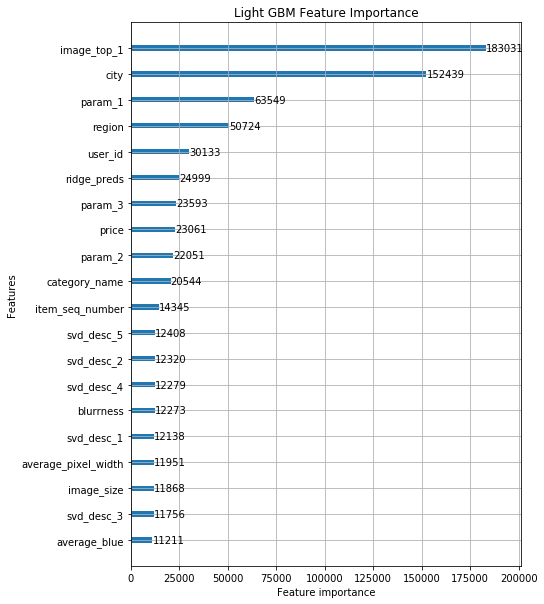

In [36]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=20, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')

print("Model Evaluation Stage")
lgpred = lgb_clf.predict(testing) 
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

In [37]:
#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub.csv",index=True,header=True)

In [38]:
lgsub.head()

,deal_probability
item_id,
6544e41a8817,0.299709
65b9484d670f,0.036990
8bab230b2ecd,0.201477
8e348601fefc,0.127248
8bd2fe400b89,0.224823
